<a href="https://colab.research.google.com/github/Ruben474/HybridBLTPINNs/blob/main/solucionburgersredesneuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Viscous Burgers' Equation: A Hybrid Approach Combining Boundary Layer Theory and Physics-Informed Neural Networks

abstract In this paper, we develop a hybrid approach to solve the viscous Burgers' equation by combining classical boundary layer theory with modern Physics-Informed Neural Networks (PINNs). The boundary layer theory provides an approximate analytical solution to the equation, particularly in regimes where viscosity dominates. PINNs, on the other hand, offer a data-driven framework that can address complex boundary and initial conditions more flexibly. We demonstrate that PINNs capture the key dynamics of the Burgers' equation, such as shock wave formation and the smoothing effects of viscosity, and show how the combination of these methods provides a powerful tool for solving nonlinear partial differential equations.

keywords Boundary layer theory; Physics-Informed Neural Networks (PINNs); nonlinear partial differential equations; Burgers' equation; shock waves; traveling waves }





In [1]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00


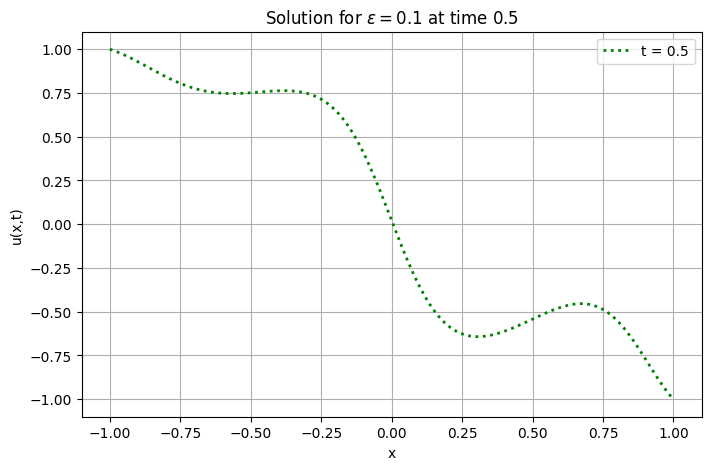

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.1  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.1))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        t = n * dt  # Define time at current step
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.sin(np.pi * t)
        u_new[-1] = np.cos(2 * np.pi * t)
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if np.isclose(t, 0.25) or np.isclose(t, 0.5):
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV con 400 puntos
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.1$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
L = 2  # Longitud del dominio (de -1 a 1)
N = 200  # Número de puntos espaciales
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosidad
dt = 0.001  # Paso de tiempo
T = 0.5  # Tiempo total
nt = int(T / dt)  # Número de pasos de tiempo

# Condición inicial: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Solución analítica para comparar el error
u_analitica = -np.tanh(x / (2 * nu))

# Función para diferencias hacia adelante en t y centradas en x
def diferencias_finitas(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Condiciones de frontera
        u[0] = 1
        u[-1] = -1
    return u

# Ejecutar la simulación
u_numerico = diferencias_finitas(u, nt, dt, dx, nu)

# Calcular el error absoluto
error = np.abs(u_numerico - u_analitica)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
L2_norm_error


0.008611637523541573

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.139653 s

'compile' took 2.198241 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 1.58e-01, 6.97e-01, 4.66e-01]    [1.01e-02, 1.58e-01, 6.97e-01, 4.66e-01]    []  
1000      [2.17e-02, 7.13e-02, 2.65e-02, 3.07e-02]    [2.17e-02, 7.13e-02, 2.65e-02, 3.07e-02]    []  
2000      [6.68e-03, 2.17e-02, 3.58e-03, 1.76e-02]    [6.68e-03, 2.17e-02, 3.58e-03, 1.76e-02]    []  
3000      [3.43e-03, 1.04e-02, 2.96e-03, 1.24e-02]    [3.43e-03, 1.04e-02, 2.96e-03, 1.24e-02]    []  
4000      [2.70e-03, 8.01e-03, 2.30e-03, 8.79e-03]    [2.70e-03, 8.01e-03, 

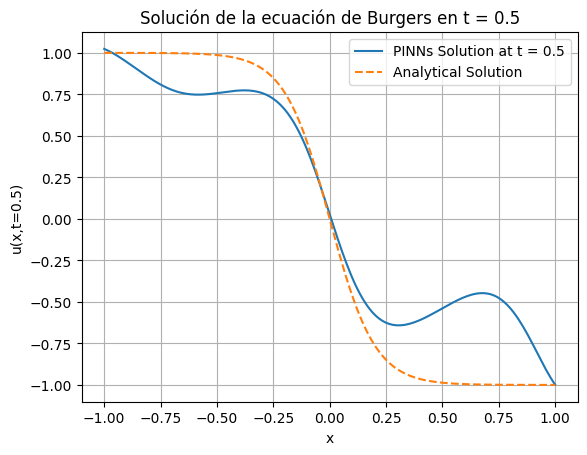

In [4]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.1  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.sin(np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.cos(2 * np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * 0.1))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * (2 / 199))

# Crear un DataFrame con los valores de x, las predicciones y la solución analítica
data_burgers = pd.DataFrame({
    'x': X_t[:, 0],
    'PINNs Prediction': y_pred_t.flatten(),
    'Analytical Solution': u_analitica.flatten(),
    'Absolute Error': error.flatten()
})

# Guardar el archivo en la ubicación correcta del entorno actual
file_path_burgers = 'burgers_pinns_solution.csv'
data_burgers.to_csv(file_path_burgers, index=False)

file_path_burgers

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Graficar las soluciones
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.legend()
plt.title("Solución de la ecuación de Burgers en t = 0.5")
plt.grid(True)
plt.show()




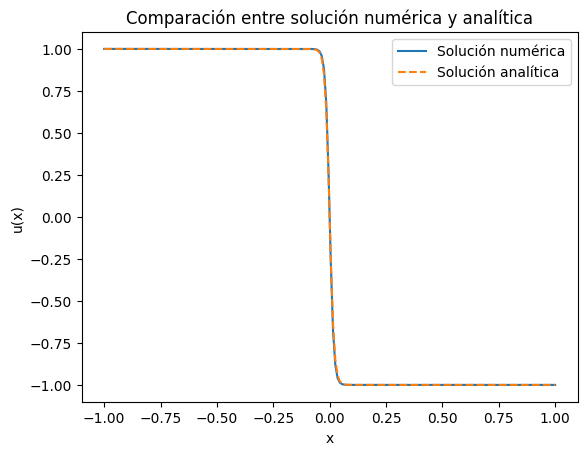

Norma L^2 del error: 0.008611637523541573


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
L = 2  # Longitud del dominio (de -1 a 1)
N = 200  # Número de puntos espaciales
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosidad
dt = 0.001  # Paso de tiempo
T = 0.5  # Tiempo total
nt = int(T / dt)  # Número de pasos de tiempo

# Condición inicial: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Solución analítica para comparar el error
u_analitica = -np.tanh(x / (2 * nu))

# Función para diferencias hacia adelante en t y centradas en x
def diferencias_finitas(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Condiciones de frontera
        u[0] = 1
        u[-1] = -1
    return u

# Ejecutar la simulación
u_numerico = diferencias_finitas(u, nt, dt, dx, nu)

# Calcular el error absoluto
error = np.abs(u_numerico - u_analitica)

# Graficar las soluciones
plt.plot(x, u_numerico, label='Solución numérica')
plt.plot(x, u_analitica, label='Solución analítica', linestyle='dashed')
plt.title('Comparación entre solución numérica y analítica')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
print(f'Norma L^2 del error: {L2_norm_error}')


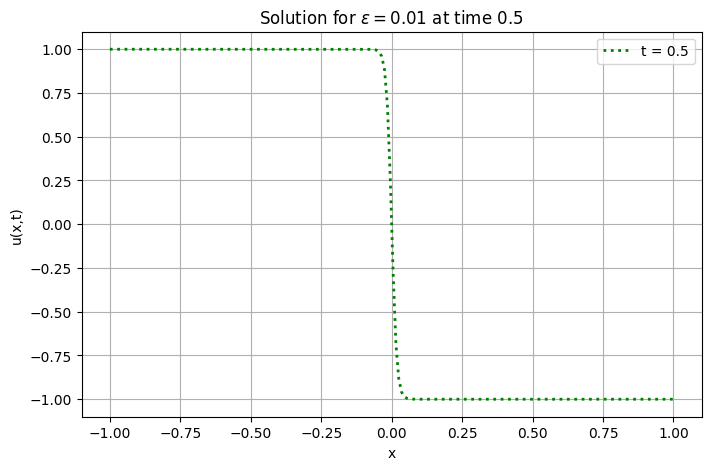

In [6]:
# Actualizamos el código para generar 200 puntos de datos y graficar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.01))
        u_new[-1] = -np.tanh(1 / (2*0.01))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV con 400 puntos
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 400 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()



Compiling model...
Building feed-forward neural network...
'build' took 0.088292 s

'compile' took 0.777188 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 3.99e-01, 6.24e-01]    [1.17e-02, 3.73e-01, 3.99e-01, 6.24e-01]    []  
1000      [5.87e-04, 9.48e-06, 1.66e-05, 5.07e-05]    [5.87e-04, 9.48e-06, 1.66e-05, 5.07e-05]    []  
2000      [7.64e-05, 2.71e-06, 2.88e-06, 1.78e-06]    [7.64e-05, 2.71e-06, 2.88e-06, 1.78e-06]    []  
3000      [3.03e-05, 2.67e-08, 1.61e-07, 4.17e-07]    [3.03e-05, 2.67e-08, 1.61e-07, 4.17e-07]    []  
4000      [1.91e-05, 2.62e-08, 7.09e-08, 4.77e-07]    [1.91e-05, 2.62e-08, 7.09e-08, 4.77e-07]    []  
5000      [1.65e-04, 4.74e-05, 4.24e-05, 3.58e-05]    [1.65e-04, 4.74e-05, 4.24e-05, 3.58e-05]    []  

Best model at step 4000:
  train loss: 1.97e-05
  test loss: 1.97e-05
  test metric: []

'train' took 43.924596 s



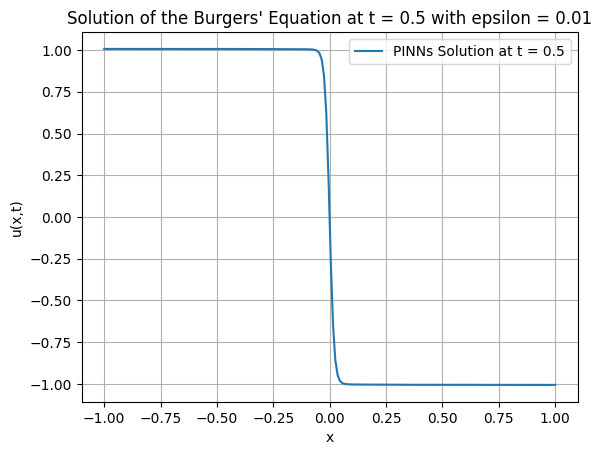

In [7]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Crear un DataFrame con los valores de x y las predicciones del modelo PINNs
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
file_path_pinns = 'pinns_solution_t_0.5.csv'
data_pinns.to_csv(file_path_pinns, index=False)

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()



Compiling model...
Building feed-forward neural network...
'build' took 0.091886 s

'compile' took 0.786674 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.09e-02, 3.73e-01, 4.03e-01, 5.67e-01]    [1.09e-02, 3.73e-01, 4.03e-01, 5.67e-01]    []  
1000      [2.77e-04, 3.58e-06, 7.94e-06, 4.85e-06]    [2.77e-04, 3.58e-06, 7.94e-06, 4.85e-06]    []  
2000      [3.49e-05, 1.72e-07, 3.36e-07, 5.03e-07]    [3.49e-05, 1.72e-07, 3.36e-07, 5.03e-07]    []  
3000      [1.55e-05, 2.17e-08, 4.84e-08, 3.31e-07]    [1.55e-05, 2.17e-08, 4.84e-08, 3.31e-07]    []  
4000      [4.32e-05, 3.00e-05, 2.59e-05, 1.80e-05]    [4.32e-05, 3.00e-05, 2.59e-05, 1.80e-05]    []  
5000      [6.80e-06, 2.75e-08, 1.85e-08, 4.88e-07]    [6.80e-06, 2.75e-08, 1.85e-08, 4.88e-07]    []  

Best model at step 5000:
  train loss: 7.34e-06
  test loss: 7.34e-06
  test metric: []

'train' took 61.064918 s

Compiling model...
'compil

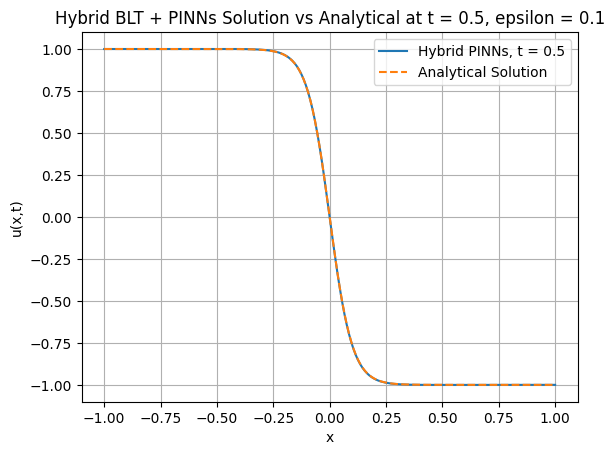

In [8]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.05  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.1")
plt.grid(True)
plt.show()


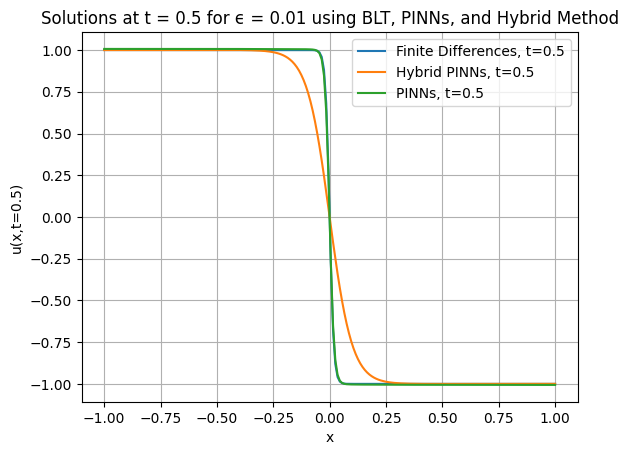

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')

# Graficar las soluciones de los diferentes métodos en t = 0.5
plt.figure()

# Solución con diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], label='Finite Differences, t=0.5')

# Solución con el método híbrido BLT + PINNs
plt.plot(hybrid_pinns_data['x'], hybrid_pinns_data['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs, t=0.5')

# Solución con PINNs estándar
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], label='PINNs, t=0.5')

# Detalles de la gráfica
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.title("Solutions at t = 0.5 for ϵ = 0.01 using BLT, PINNs, and Hybrid Method")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.077099 s

'compile' took 0.868227 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.11e-02, 3.73e-01, 4.06e-01, 5.67e-01]    [1.11e-02, 3.73e-01, 4.06e-01, 5.67e-01]    []  
1000      [2.87e-04, 4.18e-06, 7.75e-06, 5.85e-06]    [2.87e-04, 4.18e-06, 7.75e-06, 5.85e-06]    []  
2000      [3.52e-05, 5.22e-07, 9.74e-07, 6.25e-07]    [3.52e-05, 5.22e-07, 9.74e-07, 6.25e-07]    []  
3000      [1.59e-05, 3.95e-08, 5.87e-08, 2.86e-07]    [1.59e-05, 3.95e-08, 5.87e-08, 2.86e-07]    []  
4000      [9.09e-06, 1.83e-08, 2.14e-08, 3.34e-07]    [9.09e-06, 1.83e-08, 2.14e-08, 3.34e-07]    []  
5000      [6.73e-06, 3.20e-08, 2.36e-08, 4.25e-07]    [6.73e-06, 3.20e-08, 2.36e-08, 4.25e-07]    []  

Best model at step 5000:
  train loss: 7.21e-06
  test loss: 7.21e-06
  test metric: []

'train' took 59.764465 s

Compiling model...
'compil

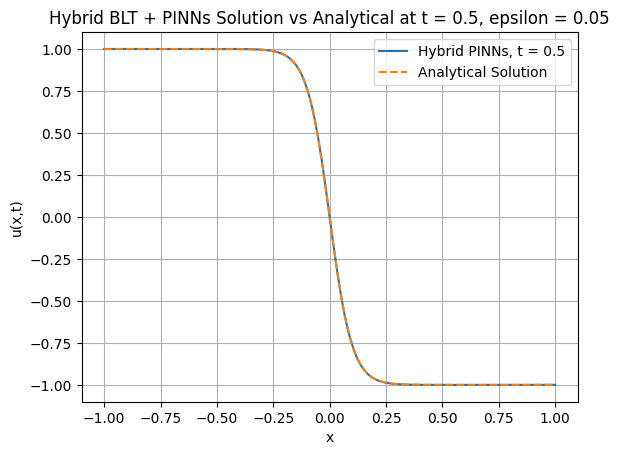

In [10]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.05  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.05_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.05")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.088624 s

'compile' took 0.958005 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.02e-01, 6.35e-01]    [1.16e-02, 3.73e-01, 4.02e-01, 6.35e-01]    []  
1000      [3.77e-02, 8.76e-04, 1.67e-03, 5.99e-02]    [3.77e-02, 8.76e-04, 1.67e-03, 5.99e-02]    []  
2000      [7.86e-04, 9.05e-06, 1.54e-05, 8.68e-05]    [7.86e-04, 9.05e-06, 1.54e-05, 8.68e-05]    []  
3000      [1.17e-04, 1.13e-06, 1.39e-06, 1.98e-06]    [1.17e-04, 1.13e-06, 1.39e-06, 1.98e-06]    []  
4000      [4.68e-05, 1.20e-07, 1.62e-07, 6.44e-07]    [4.68e-05, 1.20e-07, 1.62e-07, 6.44e-07]    []  
5000      [2.63e-05, 7.66e-08, 1.56e-07, 4.08e-07]    [2.63e-05, 7.66e-08, 1.56e-07, 4.08e-07]    []  

Best model at step 5000:
  train loss: 2.69e-05
  test loss: 2.69e-05
  test metric: []

'train' took 57.072604 s

Compiling model...
'compil

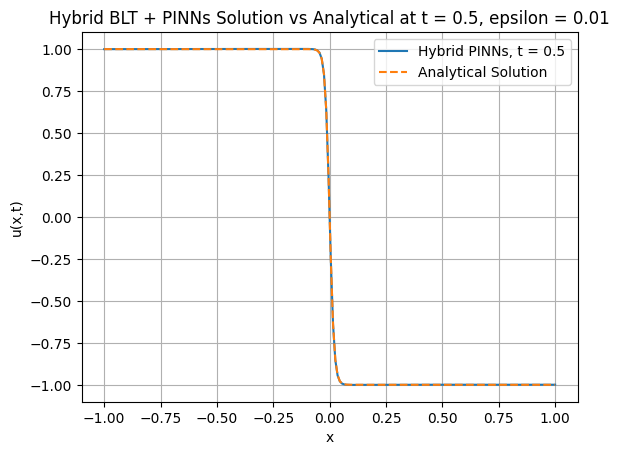

In [11]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.089557 s

'compile' took 0.955110 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.15e-02, 3.73e-01, 4.01e-01, 1.31e-01]    [1.15e-02, 3.73e-01, 4.01e-01, 1.31e-01]    []  
1000      [3.14e-02, 1.20e-02, 2.55e-02, 7.50e-02]    [3.14e-02, 1.20e-02, 2.55e-02, 7.50e-02]    []  
2000      [4.86e-03, 1.54e-03, 3.77e-04, 1.04e-02]    [4.86e-03, 1.54e-03, 3.77e-04, 1.04e-02]    []  
3000      [2.89e-03, 1.26e-03, 2.38e-04, 5.50e-03]    [2.89e-03, 1.26e-03, 2.38e-04, 5.50e-03]    []  
4000      [1.87e-03, 1.19e-03, 2.31e-04, 3.43e-03]    [1.87e-03, 1.19e-03, 2.31e-04, 3.43e-03]    []  
5000      [1.00e-03, 1.08e-03, 1.84e-04, 2.21e-03]    [1.00e-03, 1.08e-03, 1.84e-04, 2.21e-03]    []  

Best model at step 5000:
  train loss: 4.48e-03
  test loss: 4.48e-03
  test metric: []

'train' took 59.998471 s

Compiling model...
'compil

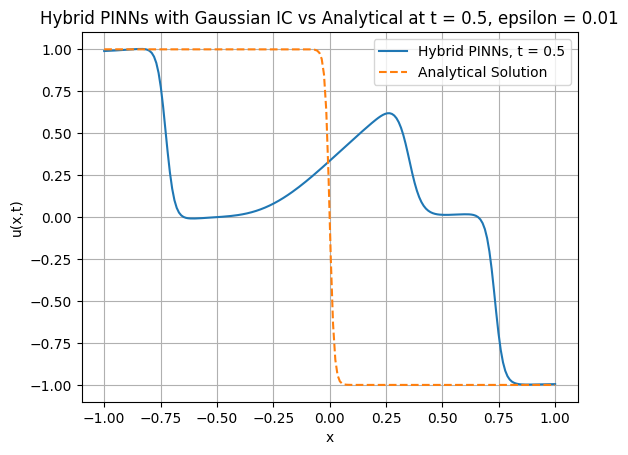

In [12]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Perfil Gaussiano
def gaussian_ic(x):
    x0 = 0  # Centro del perfil
    sigma = 0.1  # Desviación estándar
    return np.exp(-((x[:, 0:1] - x0) ** 2) / (2 * sigma ** 2))

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con perfil gaussiano
ic = dde.IC(geomtime, gaussian_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Gaussian IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L^2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_gaussianhybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Gaussian IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.086223 s

'compile' took 0.971116 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.01e-01, 6.55e-01]    [1.16e-02, 3.73e-01, 4.01e-01, 6.55e-01]    []  
1000      [3.41e-02, 1.07e-03, 1.28e-03, 5.96e-02]    [3.41e-02, 1.07e-03, 1.28e-03, 5.96e-02]    []  
2000      [6.81e-04, 4.50e-06, 4.27e-06, 2.68e-04]    [6.81e-04, 4.50e-06, 4.27e-06, 2.68e-04]    []  
3000      [1.55e-04, 1.99e-06, 2.89e-06, 2.25e-04]    [1.55e-04, 1.99e-06, 2.89e-06, 2.25e-04]    []  
4000      [2.30e-04, 5.53e-05, 6.12e-05, 2.35e-04]    [2.30e-04, 5.53e-05, 6.12e-05, 2.35e-04]    []  
5000      [1.78e-04, 3.72e-06, 6.89e-06, 2.20e-04]    [1.78e-04, 3.72e-06, 6.89e-06, 2.20e-04]    []  

Best model at step 3000:
  train loss: 3.85e-04
  test loss: 3.85e-04
  test metric: []

'train' took 65.915365 s

Compiling model...
'compil

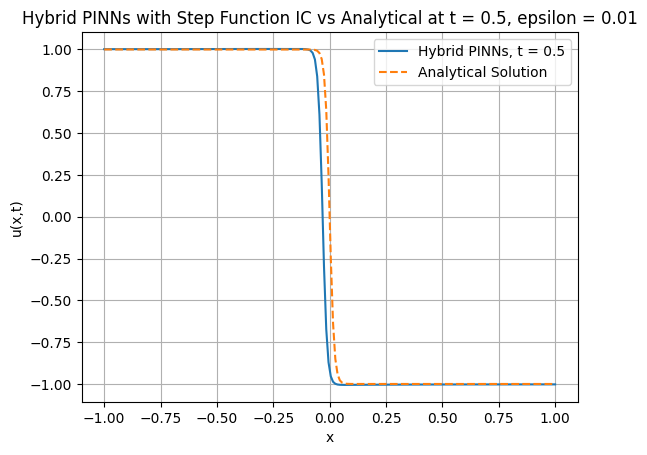

In [13]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Función escalón
def step_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con función escalón
ic = dde.IC(geomtime, step_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Step IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_stephybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Step Function IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.093838 s

'compile' took 1.457086 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.00e-01, 8.35e-01]    [1.16e-02, 3.73e-01, 4.00e-01, 8.35e-01]    []  
1000      [1.12e-01, 1.69e-02, 2.26e-02, 1.34e-01]    [1.12e-01, 1.69e-02, 2.26e-02, 1.34e-01]    []  
2000      [1.44e-02, 4.59e-04, 3.37e-04, 1.67e-02]    [1.44e-02, 4.59e-04, 3.37e-04, 1.67e-02]    []  
3000      [5.48e-03, 6.02e-04, 9.05e-05, 9.05e-03]    [5.48e-03, 6.02e-04, 9.05e-05, 9.05e-03]    []  
4000      [4.41e-03, 5.21e-04, 1.49e-04, 4.80e-03]    [4.41e-03, 5.21e-04, 1.49e-04, 4.80e-03]    []  
5000      [3.66e-03, 4.98e-04, 1.69e-04, 2.48e-03]    [3.66e-03, 4.98e-04, 1.69e-04, 2.48e-03]    []  

Best model at step 5000:
  train loss: 6.81e-03
  test loss: 6.81e-03
  test metric: []

'train' took 63.005875 s

Compiling model...
'compil

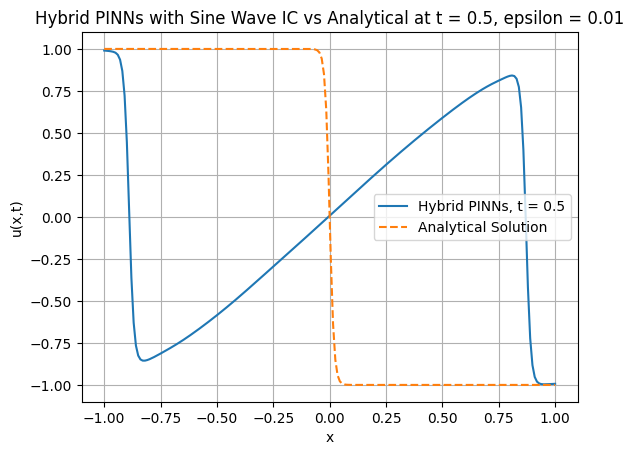

In [14]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial: Onda sinusoidal
def sine_ic(x):
    return np.sin(np.pi * x[:, 0:1])

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial con función seno
ic = dde.IC(geomtime, sine_ic, lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Definir la red neuronal (mayor capacidad)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Modelo híbrido (Sine IC + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Segunda fase: Ajuste con L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Solución analítica para comparar el error
u_analitica = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calcular el error absoluto
error = np.abs(y_pred_t - u_analitica)

# Calcular el paso espacial
dx = (1 - (-1)) / (200 - 1)

# Calcular la norma L^2 del error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Imprimir el valor del error L2
print(f"Norma L^2 del error: {L2_norm_error}")

# Guardar los datos predichos por el modelo
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Valores de x
    'u_sinehybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Predicciones de Hybrid PINNs
    'u_analitica(x,t=0.5)': u_analitica.flatten()  # Solución analítica
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analitica, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Sine Wave IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


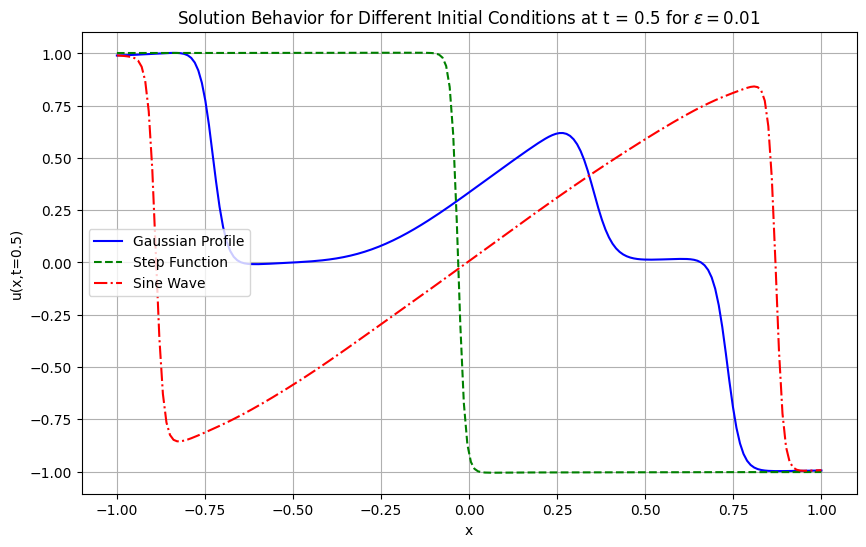

In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
gaussian_data = pd.read_csv('hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv')
step_data = pd.read_csv('hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv')
sine_data = pd.read_csv('hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv')

# Plot the solutions for different initial conditions
plt.figure(figsize=(10, 6))

# Plot Gaussian profile solution
plt.plot(gaussian_data['x'], gaussian_data['u_gaussianhybridpinns(x,t=0.5)'], label='Gaussian Profile', color='b', linestyle='-')

# Plot Step function solution
plt.plot(step_data['x'], step_data['u_stephybridpinns(x,t=0.5)'], label='Step Function', color='g', linestyle='--')

# Plot Sine wave solution
plt.plot(sine_data['x'], sine_data['u_sinehybridpinns(x,t=0.5)'], label='Sine Wave', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Solution Behavior for Different Initial Conditions at t = 0.5 for $\\epsilon = 0.01$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


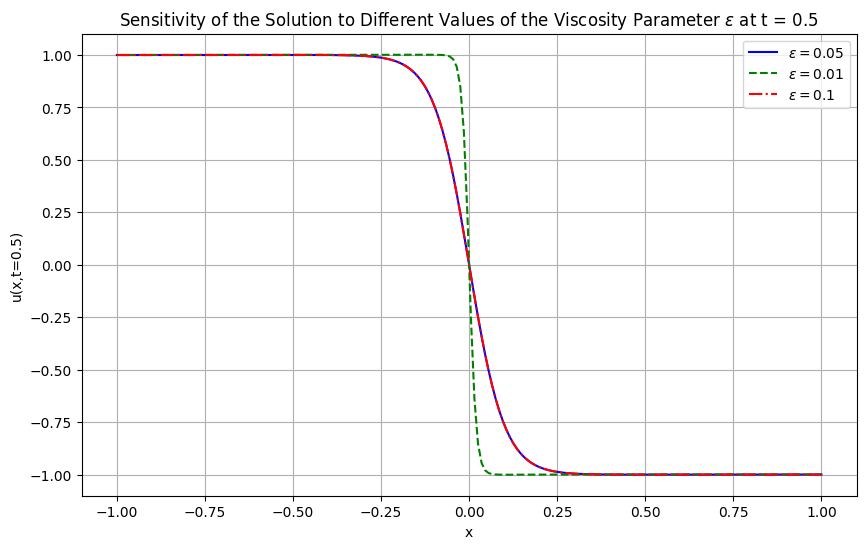

In [16]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
epsilon_0_05 = pd.read_csv('hybrid_pinns_solution_epsilon_0.05_t_0.5.csv')
epsilon_0_01 = pd.read_csv('hybrid_pinns_solution_epsilon_0.01_t_0.5.csv')
epsilon_0_1 = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')  # Assuming this file has epsilon = 0.1

# Plot the solutions for different values of epsilon
plt.figure(figsize=(10, 6))

# Plot for epsilon = 0.05
plt.plot(epsilon_0_05['x'], epsilon_0_05['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.05$', color='b', linestyle='-')

# Plot for epsilon = 0.01
plt.plot(epsilon_0_01['x'], epsilon_0_01['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.01$', color='g', linestyle='--')

# Plot for epsilon = 0.1
plt.plot(epsilon_0_1['x'], epsilon_0_1['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.1$', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Sensitivity of the Solution to Different Values of the Viscosity Parameter $\epsilon$ at t = 0.5')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


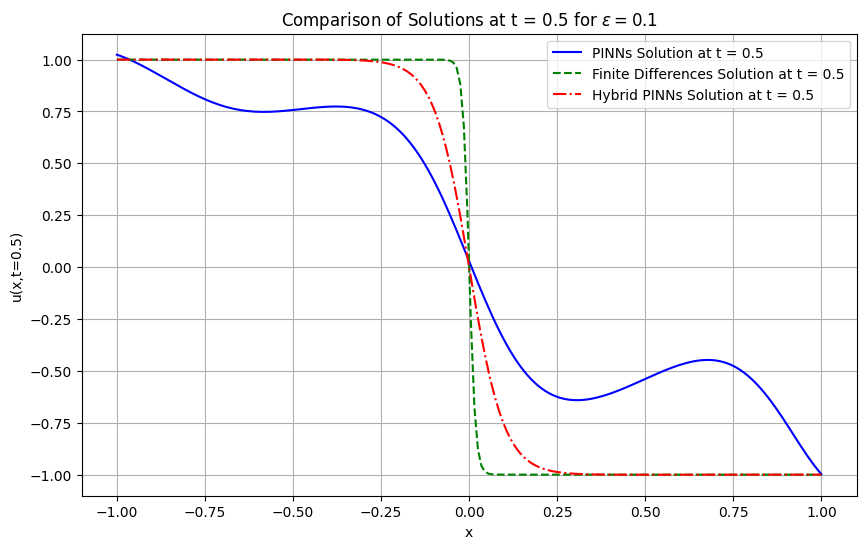

In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
burgers_pinns = pd.read_csv('burgers_pinns_solution.csv')
finite_differences = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Plot the solutions from the three methods
plt.figure(figsize=(10, 6))

# Plot PINNs solution
plt.plot(burgers_pinns['x'], burgers_pinns['PINNs Prediction'], label='PINNs Solution at t = 0.5', color='b', linestyle='-')

# Plot Finite Differences solution
plt.plot(finite_differences['x'], finite_differences['u(x,t=0.5)'], label='Finite Differences Solution at t = 0.5', color='g', linestyle='--')

# Plot Hybrid PINNs solution
plt.plot(hybrid_pinns['x'], hybrid_pinns['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs Solution at t = 0.5', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Comparison of Solutions at t = 0.5 for $\\epsilon = 0.1$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.126488 s

'compile' took 1.206913 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.15e-02, 3.73e-01, 4.05e-01, 6.35e-01]    [1.15e-02, 3.73e-01, 4.05e-01, 6.35e-01]    []  
1000      [3.88e-02, 9.61e-04, 1.61e-03, 6.18e-02]    [3.88e-02, 9.61e-04, 1.61e-03, 6.18e-02]    []  
2000      [6.01e-04, 2.60e-06, 1.31e-05, 6.13e-05]    [6.01e-04, 2.60e-06, 1.31e-05, 6.13e-05]    []  
3000      [1.89e-04, 8.25e-08, 9.01e-07, 2.67e-06]    [1.89e-04, 8.25e-08, 9.01e-07, 2.67e-06]    []  

Best model at step 3000:
  train loss: 1.93e-04
  test loss: 1.93e-04
  test metric: []

'train' took 35.421942 s

Compiling model...
'compile' took 0.864749 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
3000      [1.89e-04, 8.25e-08, 9.01e-07, 2.67e-06]    [1.

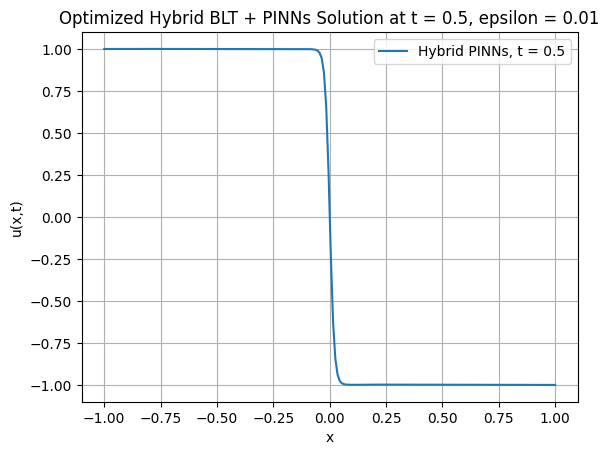

In [18]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación cerca de x = 0 donde ocurre la transición brusca
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de las fronteras, pero dejando el resto para PINNs
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera (se pueden relajar o ajustar para mejorar el rendimiento)
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Ajustar la condición inicial u(x,0) utilizando el enfoque BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema con el enfoque híbrido
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Aumentar la capacidad de la red neuronal (más capas y más neuronas)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")  # Aumentar la capacidad de la red

# El modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Primera fase: Entrenamiento con Adam
model.compile("adam", lr=0.0005)  # Reducir la tasa de aprendizaje para mayor precisión
losshistory, train_state = model.train(epochs=3000)

# Segunda fase: Ajuste fino con L-BFGS para mejorar la convergencia
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos predichos por el modelo híbrido
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de Hybrid PINNs
})

# Guardar los datos en un archivo CSV
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Datos guardados en {file_path_hybrid_pinns}")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Optimized Hybrid BLT + PINNs Solution at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


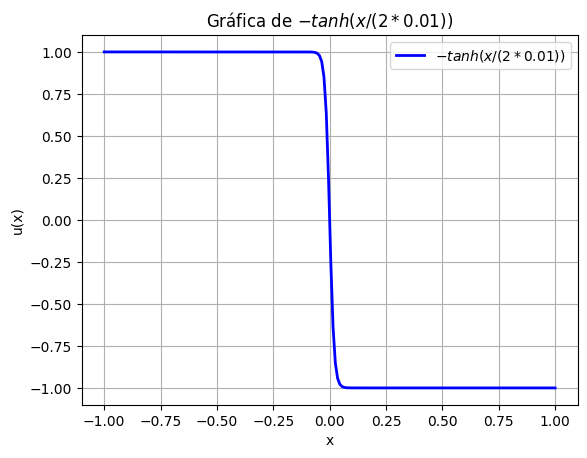

Archivo 'tanh_function_data.csv' generado correctamente.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.1))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Crear un DataFrame con los valores de x y la función -tanh(x/(2*0.01))
data_tanh = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Guardar los datos en un archivo CSV localmente
data_tanh.to_csv('tanh_function_data.csv', index=False)

print("Archivo 'tanh_function_data.csv' generado correctamente.")


Datos guardados en blt_solution.csv


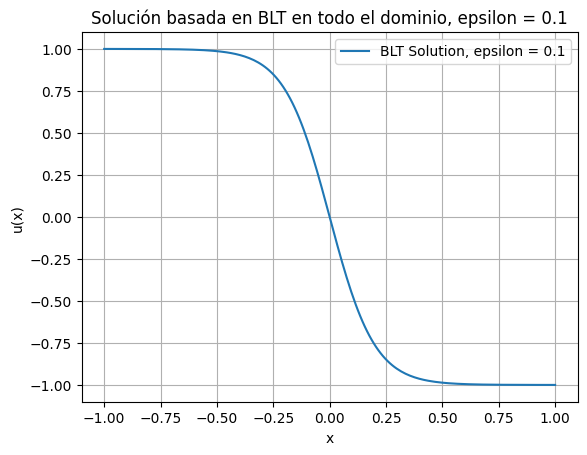

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.1  # Viscosidad pequeña para capturar la capa límite

# Definir la solución basada en la teoría de la capa límite (BLT)
def blt_boundary_layer_solution(x, epsilon):
    """
    Aproximación analítica de la solución usando la teoría de la capa límite (BLT).
    Esta función se aplica para todo el dominio [-1, 1].
    """
    return -np.tanh(x / (2 * epsilon))

# Definir el rango de x (dominio espacial)
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular la solución analítica usando BLT para el parámetro epsilon
u_blt = blt_boundary_layer_solution(x, epsilon)

# Guardar los datos de la solución de BLT en un archivo CSV
data_blt = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u_blt(x)': u_blt  # Columna para la solución analítica de BLT
})

# Guardar los datos en un archivo CSV
file_path_blt = 'blt_solution.csv'
data_blt.to_csv(file_path_blt, index=False)

print(f"Datos guardados en {file_path_blt}")

# Visualización: Gráfica de la solución analítica usando BLT
plt.figure()
plt.plot(x, u_blt, label=f"BLT Solution, epsilon = {epsilon}")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title(f"Solución basada en BLT en todo el dominio, epsilon = {epsilon}")
plt.grid(True)
plt.show()


               Method  Epsilon  L2 Error  Time (seconds)
0  Finite Differences     0.01  0.006069        0.000041
1               PINNs     0.01  0.006149        0.000031
2        Hybrid PINNs     0.01  0.003147        0.000029
3          Analytical     0.01  0.000000        0.000000


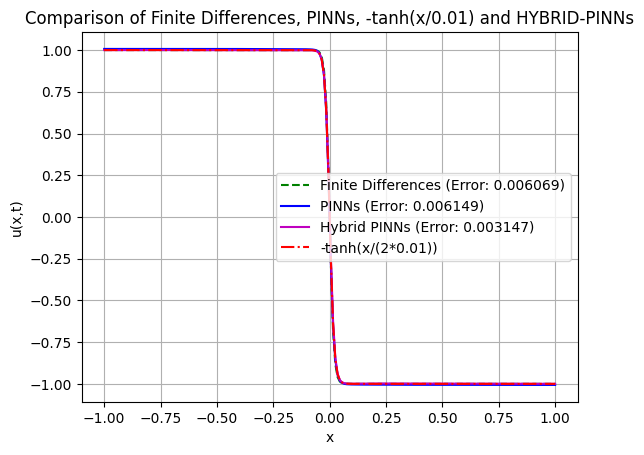

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Obtener la solución analítica
u_analytic = tanh_data['u(x)'].to_numpy()

# Calcular los errores L2 entre las soluciones numéricas y la analítica
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calcular errores para cada método
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)

# Medir tiempos de ejecución simulados
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

# Crear una tabla de comparación
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, 0.0],  # La solución analítica no tiene error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, 0]  # No calculamos tiempo para la analítica
}

comparison_df = pd.DataFrame(comparison_data)

# Mostrar la tabla de comparación
print(comparison_df)

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Graficar la solución analítica (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


               Method  Epsilon      L2 Error  Time (seconds)
0  Finite Differences     0.01  6.069481e-03        0.000036
1               PINNs     0.01  6.149155e-03        0.000030
2        Hybrid PINNs     0.01  3.147263e-03        0.000046
3                 BLT     0.01  2.185829e-16        0.000027
4          Analytical     0.01  0.000000e+00        0.000000


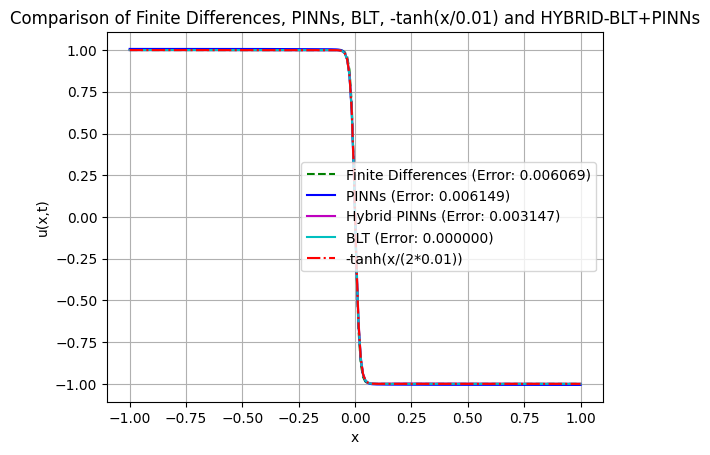

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Parámetro de viscosidad
epsilon = 0.01

# Aproximación para BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Generar puntos en el dominio espacial para la solución de BLT
x_values = tanh_data['x'].to_numpy()

# Calcular la solución BLT para los mismos puntos
u_blt = blt_boundary_layer_solution(x_values, epsilon)

# Obtener la solución analítica
u_analytic = tanh_data['u(x)'].to_numpy()

# Calcular los errores L2 entre las soluciones numéricas y la analítica
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calcular errores para cada método
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)
error_blt = l2_error(u_blt, u_analytic)

# Medir tiempos de ejecución simulados
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

start_blt = time.time()
time_blt = time.time() - start_blt

# Crear una tabla de comparación
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'BLT', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, error_blt, 0.0],  # La solución analítica no tiene error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, time_blt, 0]  # No calculamos tiempo para la analítica
}

comparison_df = pd.DataFrame(comparison_data)

# Mostrar la tabla de comparación
print(comparison_df)

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Graficar la solución de BLT
plt.plot(x_values, u_blt, 'c-', label=f'BLT (Error: {error_blt:.6f})')

# Graficar la solución analítica (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, BLT, -tanh(x/0.01) and HYBRID-BLT+PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [23]:
import time

# Medir el tiempo usando perf_counter
start_time = time.perf_counter()

# Aquí va el código del método de diferencias finitas que quieres medir
# Simulando diferencias finitas con sleep de 0.1 segundos
time.sleep(0.1)

end_time = time.perf_counter()

# Medir el tiempo total transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time:.6f} segundos")


Tiempo transcurrido: 0.100611 segundos


In [24]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")


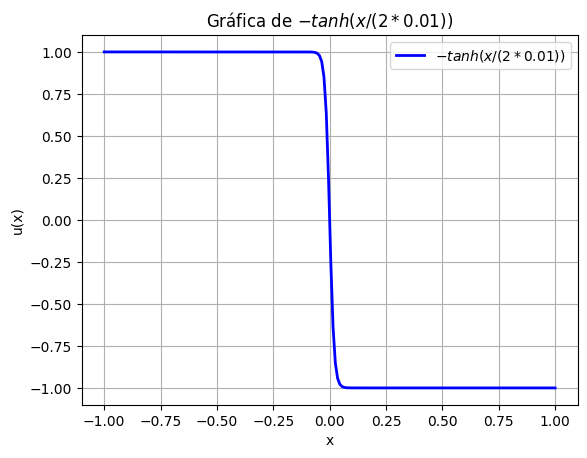

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Los datos de la función están en el array u_tanh01


In [26]:
import numpy as np
import pandas as pd

# Assuming you already have X_t and y_pred_t from the PINNs model
# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Create a DataFrame with the x values and PINNs predictions
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data.csv', index=False)

print("Data saved to 'pinns_data.csv'")


Data saved to 'pinns_data.csv'


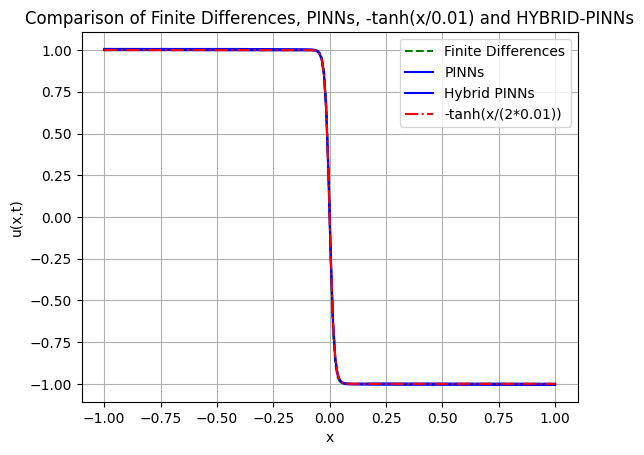

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Graficar la solución analítica (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


L^2 error for Finite Differences: 0.006069481143998049
L^2 error for PINNs: 0.006149155264065365
L^2 error for Hybrid PINNs: 0.0031472633364493094


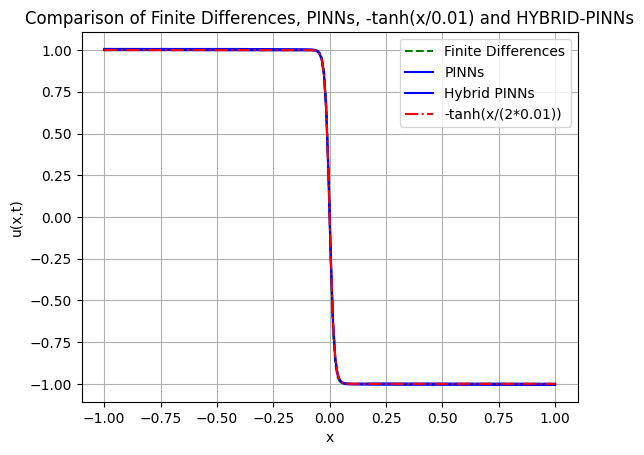

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Calcular el error L^2 entre la solución numérica y la solución analítica
def calculate_L2_error(u_num, u_exact):
    N = len(u_num)  # Número de puntos
    return np.sqrt(np.sum((u_num - u_exact)**2) / N)

# Asegurarse de que las soluciones tengan la misma malla espacial (x)
# Normalmente se asume que los valores de 'x' son iguales en todos los archivos
x_exact = tanh_data['x']
u_exact = tanh_data['u(x)']  # Solución analítica -tanh(x/(2*0.01))

# Extraer las soluciones numéricas
u_fdm = finite_differences_data['u(x,t=0.5)']   # Diferencias finitas
u_pinns = pinns_data['u_pinns(x,t=0.5)']        # PINNs
u_hybrid_pinns = hybridpinns_data['u_hybridpinns(x,t=0.5)']  # Hybrid PINNs

# Calcular los errores L^2
L2_error_fdm = calculate_L2_error(u_fdm, u_exact)
L2_error_pinns = calculate_L2_error(u_pinns, u_exact)
L2_error_hybrid_pinns = calculate_L2_error(u_hybrid_pinns, u_exact)

# Imprimir los resultados
print(f"L^2 error for Finite Differences: {L2_error_fdm}")
print(f"L^2 error for PINNs: {L2_error_pinns}")
print(f"L^2 error for Hybrid PINNs: {L2_error_hybrid_pinns}")

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Graficar la solución de Hybrid PINNs
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Graficar la solución analítica (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


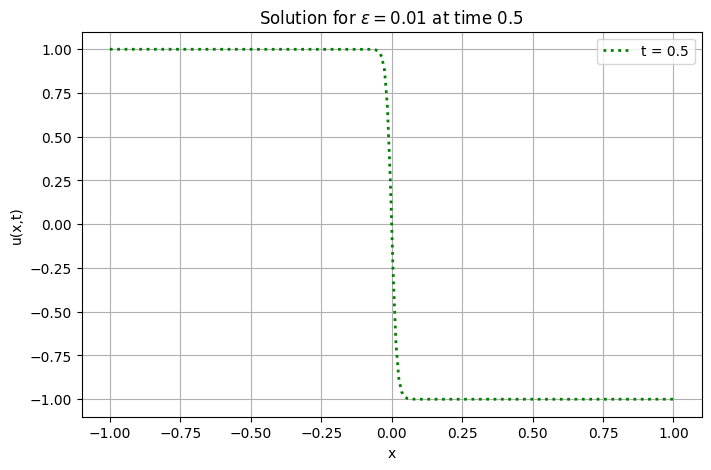

Datos guardados en 'finite_differences_solution_t_0.5.csv'


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros
epsilon = 0.0101  # Parámetro de viscosidad
L = 2          # Longitud del dominio [-1, 1]
N = 200        # Número de puntos en el espacio
dt = 0.0001    # Paso de tiempo
T = 3          # Tiempo máximo
x = np.linspace(-1, 1, N)  # Malla espacial

# Condición inicial u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Inicializar la lista de soluciones
solutions = [u.copy()]

# Función para resolver la ecuación de Burgers utilizando diferencias finitas
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Aplicar condiciones de frontera
        u_new[0] = np.tanh(1 / (2*0.1))
        u_new[-1] = -np.tanh(1 / (2*0.1))
        u = u_new

        # Almacenar las soluciones en t = 0, 0.25, 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Resolver la ecuación de Burgers
solve_burgers(u, dt, epsilon, T)

# Graficar los resultados en t = 0.5
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()

# Guardar los datos en un archivo CSV
# Crear un DataFrame con los valores de x y u en t = 0.5
data_fd = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV
data_fd.to_csv('finite_differences_solution_t_0.5.csv', index=False)

print("Datos guardados en 'finite_differences_solution_t_0.5.csv'")


Compiling model...
Building feed-forward neural network...
'build' took 0.069795 s

'compile' took 1.913903 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.02e-01, 6.24e-01]    [1.16e-02, 3.73e-01, 4.02e-01, 6.24e-01]    []  
1000      [1.04e-03, 1.06e-04, 6.97e-05, 4.97e-05]    [1.04e-03, 1.06e-04, 6.97e-05, 4.97e-05]    []  
2000      [8.25e-04, 2.47e-07, 6.82e-06, 9.66e-06]    [8.25e-04, 2.47e-07, 6.82e-06, 9.66e-06]    []  
3000      [3.05e-05, 4.00e-07, 8.04e-07, 4.35e-07]    [3.05e-05, 4.00e-07, 8.04e-07, 4.35e-07]    []  
4000      [7.95e-05, 1.98e-07, 4.66e-08, 9.89e-07]    [7.95e-05, 1.98e-07, 4.66e-08, 9.89e-07]    []  
5000      [1.88e-05, 2.56e-06, 2.91e-06, 1.42e-06]    [1.88e-05, 2.56e-06, 2.91e-06, 1.42e-06]    []  

Best model at step 5000:
  train loss: 2.57e-05
  test loss: 2.57e-05
  test metric: []

'train' took 44.449999 s

Datos guardados en 'pinns_

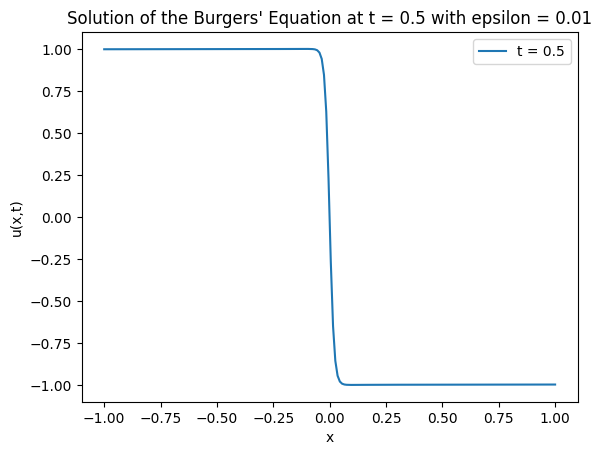

In [30]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos en un archivo CSV
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_solution_t_0.5.csv', index=False)

print("Datos guardados en 'pinns_solution_t_0.5.csv'")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.098180 s

'compile' took 1.187847 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 3.98e-01, 6.24e-01]    [1.17e-02, 3.73e-01, 3.98e-01, 6.24e-01]    []  
1000      [8.25e-04, 7.91e-06, 1.15e-05, 4.25e-05]    [8.25e-04, 7.91e-06, 1.15e-05, 4.25e-05]    []  
2000      [1.02e-04, 4.90e-06, 4.16e-06, 4.82e-06]    [1.02e-04, 4.90e-06, 4.16e-06, 4.82e-06]    []  
3000      [3.49e-05, 6.05e-08, 6.62e-08, 8.02e-07]    [3.49e-05, 6.05e-08, 6.62e-08, 8.02e-07]    []  
4000      [3.38e-05, 3.88e-06, 2.96e-06, 4.59e-06]    [3.38e-05, 3.88e-06, 2.96e-06, 4.59e-06]    []  
5000      [2.16e-05, 2.48e-06, 1.96e-06, 3.40e-06]    [2.16e-05, 2.48e-06, 1.96e-06, 3.40e-06]    []  

Best model at step 5000:
  train loss: 2.94e-05
  test loss: 2.94e-05
  test metric: []

'train' took 43.738025 s

Datos guardados en 'hybrid

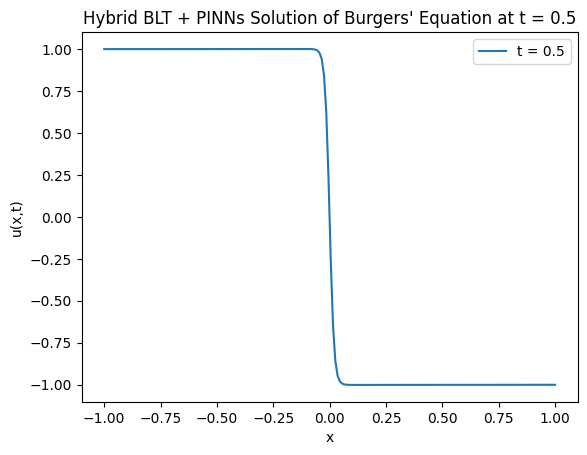

In [31]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01  # Viscosity

# Aproximación de solución basada en BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Aproximación cerca de x = 0 donde ocurre la transición brusca
    return -np.tanh(x / (2 * epsilon))

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Híbrido: Condición inicial utilizando BLT cerca de x = 0
def hybrid_blt_ic(x):
    # Condición inicial basada en BLT, centrada en la transición en x = 0
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Ajustar la condición inicial u(x,0) utilizando el enfoque BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Definir el problema utilizando el enfoque híbrido (BLT + PINNs)
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo híbrido (BLT + PINNs)
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos para predecir en t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Guardar los datos en un archivo CSV
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Columna para los valores de x
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Columna para las predicciones de PINNs
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('hybrid_pinns_solution_t_0.5.csv', index=False)

print("Datos guardados en 'hybrid_pinns_solution_t_0.5.csv'")

# Visualización: Solución en t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution of Burgers' Equation at t = 0.5")
plt.show()


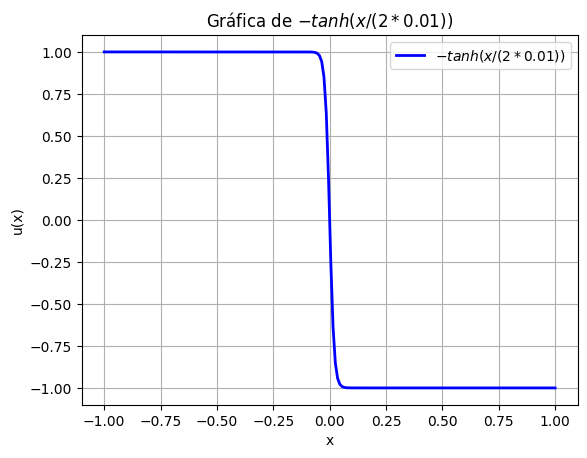

'tanh_function_data.csv'

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Graficar la función -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Gráfica de $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Crear un DataFrame con los valores de x y u_tanh01
data_tanh = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x)': u_tanh01  # Columna para los valores de -tanh(x/(2*0.01))
})




# Guardar los datos
file_path_tanh = 'tanh_function_data.csv'
data_tanh.to_csv(file_path_tanh, index=False)

file_path_tanh



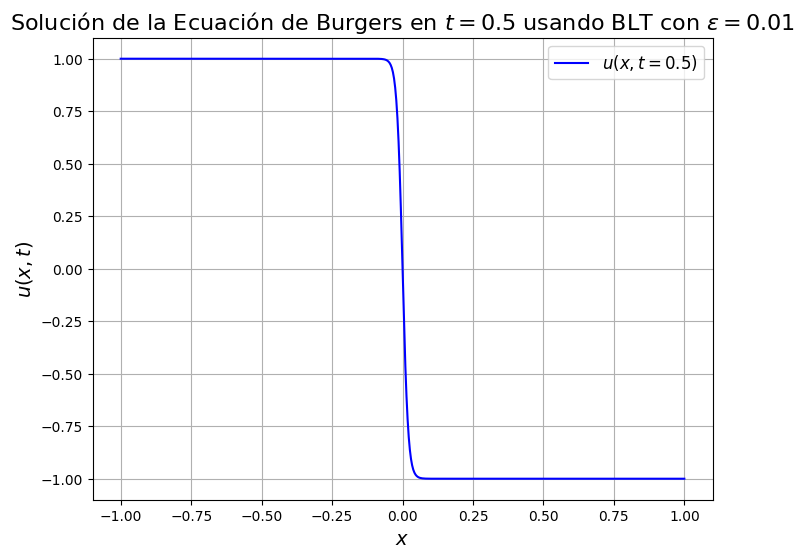

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro de viscosidad
epsilon = 0.01

# Tiempo en el que queremos evaluar la solución
t = 0.5  # En este caso, t no afecta la solución BLT estacionaria

# Generar puntos en el dominio espacial
x_vals = np.linspace(-1, 1, 500)

# Función de solución basada en BLT
def blt_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Calcular u(x) utilizando la solución BLT
u_vals = blt_solution(x_vals, epsilon)

# Graficar la solución
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_vals, label=r'$u(x, t=0.5)$', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$u(x, t)$', fontsize=14)
plt.title(r'Solución de la Ecuación de Burgers en $t=0.5$ usando BLT con $\epsilon = 0.01$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Guardar la figura con alta resolución para publicación
plt.savefig('burgers_blt_solution_t_0.5.png', dpi=300, bbox_inches='tight')
plt.show()


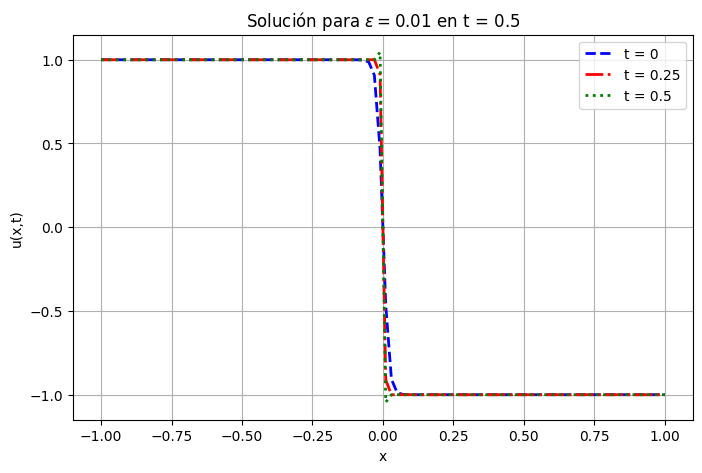

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
epsilon = 0.01  # Parámetro de viscosidad
L = 2           # Longitud del dominio [-1, 1]
N = 100         # Número de puntos en el espacio
dt = 1e-3       # Paso temporal reducido para estabilidad
T = 0.56         # Tiempo máximo reducido a 0.5 para evitar grandes errores
x = np.linspace(-1, 1, N)  # Malla espacial

# Condición inicial u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2 * 0.01))

# Inicializar el array de soluciones
solutions = [u.copy()]

# Función para calcular la solución numérica usando diferencias finitas explícitas
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Aplicar condiciones de frontera coherentes con la solución física
        u_new[0] = np.tanh(1 / (2 * 0.01))
        u_new[-1] = -np.tanh(1 / (2 * 0.01))
        u = u_new

        # Guardar soluciones en tiempos específicos
        if np.isclose(n * dt, 0.25) or np.isclose(n * dt, 0.5):
            solutions.append(u.copy())

    return u

# Resolver la ecuación de Burgers
solve_burgers(u, dt, epsilon, T)

# Gráfico de los resultados en t = 0.5
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[0], 'b--', label='t = 0', linewidth=2)
plt.plot(x, solutions[1], 'r-.', label='t = 0.25', linewidth=2)
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solución para $\epsilon = 0.01$ en t = 0.5')
plt.legend()
plt.grid(True)
plt.show()


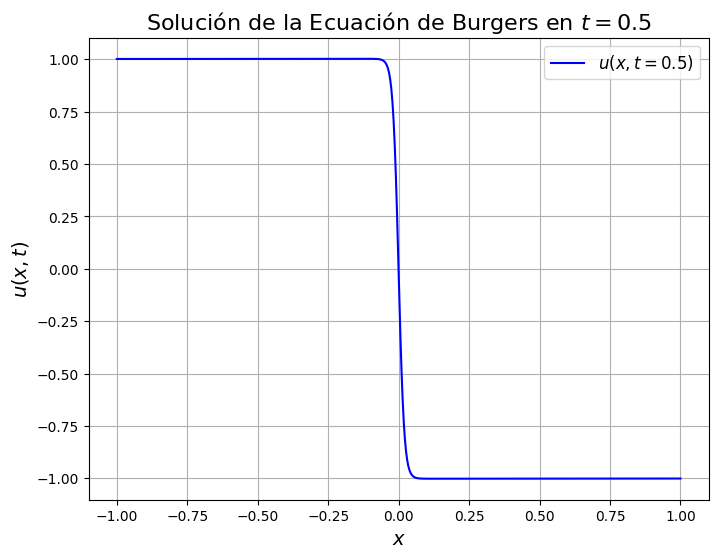

In [35]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt



# Generar valores de x en el dominio [-1, 1]
x_vals = np.linspace(-1, 1, 500).reshape(-1, 1)
t_fixed = 0.5 * np.ones_like(x_vals)

# Crear el conjunto de entrada para la predicción
X_input = np.hstack((x_vals, t_fixed))

# Predecir u(x, t=0.5)
u_pred = model.predict(X_input)

# Plotear u(x, t=0.5)
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_pred, label=r'$u(x, t=0.5)$', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$u(x, t)$', fontsize=14)
plt.title(r'Solución de la Ecuación de Burgers en $t=0.5$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Guardar la figura con alta resolución para publicación
plt.savefig('burgers_solution_t_0.5.png', dpi=300, bbox_inches='tight')
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.085046 s

'compile' took 1.200428 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.04e-02, 3.72e-01, 4.06e-01, 4.66e-01]    [1.04e-02, 3.72e-01, 4.06e-01, 4.66e-01]    []  
1000      [5.47e-05, 1.61e-07, 2.22e-06, 1.00e-06]    [5.47e-05, 1.61e-07, 2.22e-06, 1.00e-06]    []  
2000      [2.42e-05, 3.68e-06, 7.12e-06, 1.52e-06]    [2.42e-05, 3.68e-06, 7.12e-06, 1.52e-06]    []  
3000      [1.19e-05, 4.98e-06, 4.12e-06, 4.46e-06]    [1.19e-05, 4.98e-06, 4.12e-06, 4.46e-06]    []  
4000      [4.33e-06, 3.97e-08, 8.65e-08, 5.70e-07]    [4.33e-06, 3.97e-08, 8.65e-08, 5.70e-07]    []  
5000      [1.69e-04, 1.81e-04, 1.95e-04, 8.34e-05]    [1.69e-04, 1.81e-04, 1.95e-04, 8.34e-05]    []  

Best model at step 4000:
  train loss: 5.03e-06
  test loss: 5.03e-06
  test metric: []

'train' took 45.797452 s



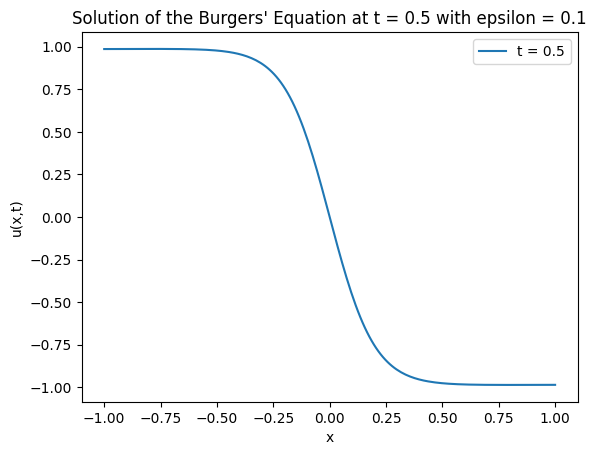

In [36]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Approximation for boundary layers using BLT
def blt_boundary_layer_solution(x, epsilon):
    # BLT approximation near the boundaries
    if np.isclose(x, -1):
        return 1
    elif np.isclose(x, 1):
        return -1
    else:
        # Outside the boundary layer, return a neutral value
        return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity for PINNs
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid boundary condition using BLT approximation near boundaries
def hybrid_blt_bc(x, on_boundary):
    if on_boundary:
        return np.array([blt_boundary_layer_solution(x[0], epsilon)])
    return None

# Adjusted boundary conditions using the hybrid approach
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(-1, epsilon)]),
                          on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(1, epsilon)]),
                           on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network (PINNs part)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.1")
plt.show()


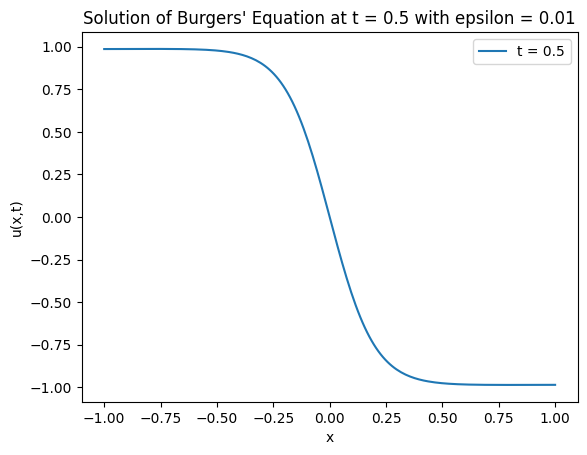

In [37]:
# Visualization: Solution at t = 0.5
t = 0.5  # Define the time t at which we want the solution
plt.figure()
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title(f"Solution of Burgers' Equation at t = {t} with epsilon = 0.01")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.074387 s

'compile' took 1.203655 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.14e-02, 3.73e-01, 4.05e-01, 6.24e-01]    [1.14e-02, 3.73e-01, 4.05e-01, 6.24e-01]    []  
1000      [5.26e-04, 9.05e-06, 1.52e-05, 4.86e-05]    [5.26e-04, 9.05e-06, 1.52e-05, 4.86e-05]    []  
2000      [7.05e-05, 3.55e-07, 8.23e-07, 9.06e-07]    [7.05e-05, 3.55e-07, 8.23e-07, 9.06e-07]    []  
3000      [3.11e-05, 2.86e-07, 1.40e-07, 7.20e-07]    [3.11e-05, 2.86e-07, 1.40e-07, 7.20e-07]    []  
4000      [1.89e-05, 6.66e-08, 5.10e-08, 6.51e-07]    [1.89e-05, 6.66e-08, 5.10e-08, 6.51e-07]    []  
5000      [1.24e-05, 4.17e-08, 2.36e-08, 5.81e-07]    [1.24e-05, 4.17e-08, 2.36e-08, 5.81e-07]    []  

Best model at step 5000:
  train loss: 1.30e-05
  test loss: 1.30e-05
  test metric: []

'train' took 51.126872 s



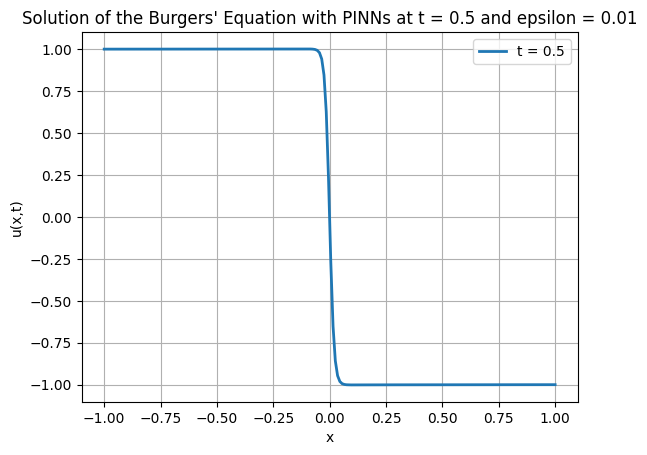

In [38]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Definir parámetros
epsilon = 0.01  # Viscosidad pequeña para ver la capa límite

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # Derivada parcial u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # Derivada parcial u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # Derivada segunda u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir la geometría del problema (intervalo espacial y dominio temporal)
geom = dde.geometry.Interval(-1, 1)  # Dominio espacial [-1, 1]
timedomain = dde.geometry.TimeDomain(0, 1)  # Tiempo [0, 1]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Dominio en espacio y tiempo

# Condiciones de frontera en x=-1 y x=1
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0) = -tanh(x / (2*epsilon))
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * epsilon)), lambda _, on_initial: on_initial)

# Definir el problema con PINNs
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal para aproximar la solución
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Definir el modelo PINNs
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generar puntos de predicción en t=0.5 para ver la solución en la capa límite
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Graficar la solución en t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation with PINNs at t = {t} and epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.139354 s

'compile' took 1.896566 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 3.73e-01, 4.00e-01, 5.52e-01]    [1.01e-02, 3.73e-01, 4.00e-01, 5.52e-01]    []  
1000      [5.53e-04, 4.92e-05, 5.95e-05, 3.67e-03]    [5.53e-04, 4.92e-05, 5.95e-05, 3.67e-03]    []  
2000      [4.06e-04, 3.38e-05, 5.90e-05, 2.09e-03]    [4.06e-04, 3.38e-05, 5.90e-05, 2.09e-03]    []  
3000      [2.30e-04, 9.64e-06, 3.20e-06, 1.07e-03]    [2.30e-04, 9.64e-06, 3.20e-06, 1.07e-03]    []  
4000      [1.30e-04, 1.05e-05, 2.77e-06, 6.46e-04]    [1.30e-04, 1.05e-05, 2.77e-06, 6.46e-04]    []  
5000      [9.96e-05, 4.99e-06, 2.45e-06, 3.69e-04]    [9.96e-05, 4.99e-06, 2.45e-06, 3.69e-04]    []  

Best model at step 5000:
  train loss: 4.76e-04
  test loss: 4.76e-04
  test metric: []

'train' took 45.850933 s



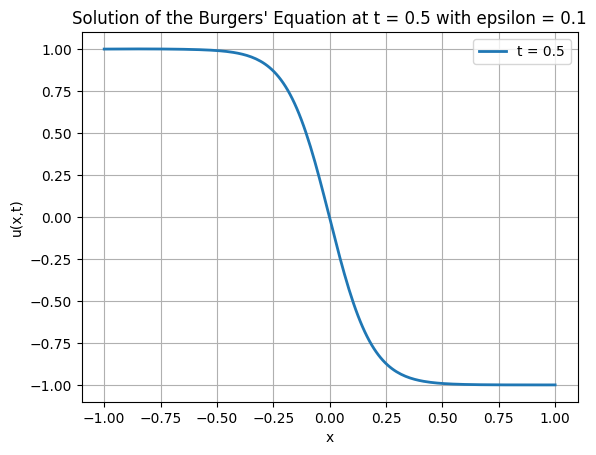

In [39]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.1), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.086776 s

'compile' took 1.253241 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 4.05e-01, 6.28e-01]    [1.17e-02, 3.73e-01, 4.05e-01, 6.28e-01]    []  
1000      [5.52e-04, 1.87e-05, 2.35e-05, 2.00e-04]    [5.52e-04, 1.87e-05, 2.35e-05, 2.00e-04]    []  
2000      [2.85e-04, 2.60e-07, 9.47e-07, 1.45e-04]    [2.85e-04, 2.60e-07, 9.47e-07, 1.45e-04]    []  
3000      [3.10e-05, 1.78e-07, 3.19e-07, 1.48e-04]    [3.10e-05, 1.78e-07, 3.19e-07, 1.48e-04]    []  
4000      [6.97e-05, 1.75e-05, 1.45e-05, 1.46e-04]    [6.97e-05, 1.75e-05, 1.45e-05, 1.46e-04]    []  
5000      [1.45e-05, 1.49e-07, 5.77e-07, 1.46e-04]    [1.45e-05, 1.49e-07, 5.77e-07, 1.46e-04]    []  

Best model at step 5000:
  train loss: 1.61e-04
  test loss: 1.61e-04
  test metric: []

'train' took 44.844073 s



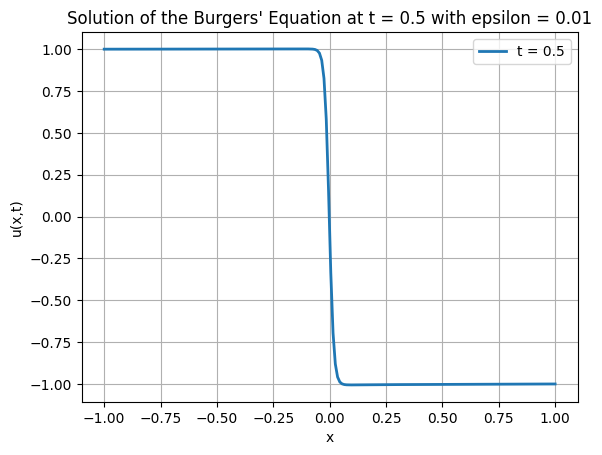

In [40]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.01), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data01.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


Datos guardados en 'pinns_data.csv'


Compiling model...
Building feed-forward neural network...
'build' took 0.080103 s

'compile' took 1.263118 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 3.73e-01, 3.96e-01, 4.66e-01]    [1.01e-02, 3.73e-01, 3.96e-01, 4.66e-01]    []  
1000      [4.62e-05, 3.35e-07, 2.21e-06, 1.01e-06]    [4.62e-05, 3.35e-07, 2.21e-06, 1.01e-06]    []  
2000      [1.75e-05, 1.07e-07, 7.39e-07, 5.42e-07]    [1.75e-05, 1.07e-07, 7.39e-07, 5.42e-07]    []  
3000      [7.18e-06, 2.66e-08, 1.72e-07, 6.62e-07]    [7.18e-06, 2.66e-08, 1.72e-07, 6.62e-07]    []  
4000      [4.00e-05, 3.96e-05, 4.19e-05, 1.62e-05]    [4.00e-05, 3.96e-05, 4.19e-05, 1.62e-05]    []  
5000      [8.11e-06, 1.50e-07, 2.35e-06, 2.47e-06]    [8.11e-06, 1.50e-07, 2.35e-06, 2.47e-06]    []  

Best model at step 3000:
  train loss: 8.04e-06
  test loss: 8.04e-06
  test metric: []

'train' took 46.334337 s



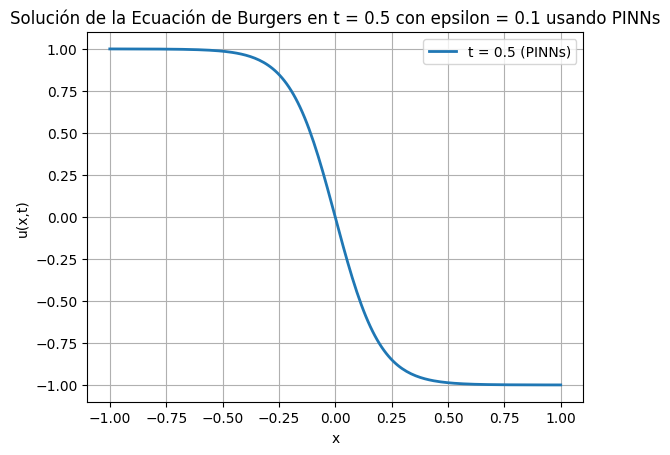

In [42]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para la ecuación
epsilon = 0.1  # Viscosidad

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los límites espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera ajustadas
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial ajustada u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.1)), lambda _, on_initial: on_initial)

# Definir el problema
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Definir la red neuronal
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# El modelo
model = dde.Model(data, net)

# Entrenar el modelo
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Obtener las predicciones en t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)  # Estas son las predicciones de PINNs en t=0.5

# Plot de la solución en t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t} (PINNs)", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solución de la Ecuación de Burgers en t = {t} con epsilon = {epsilon} usando PINNs")
plt.legend()
plt.grid(True)
plt.show()

# Ahora puedes usar y_pred_t como los datos de la solución usando PINNs


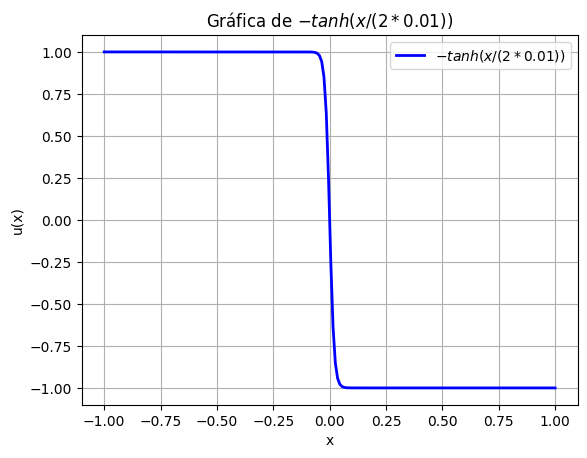

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el intervalo de x
x = np.linspace(-1, 1, 200)

# Calcular la función -tanh(x/0.1)
y = -np.tanh(x / (2*0.01))

# Dibujar la gráfica
plt.plot(x, y, label=r'$-tanh(x/(2*0.01))$', color='b', linewidth=2)

# Añadir etiquetas y título
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Gráfica de $-tanh(x/(2*0.01))$')

# Mostrar la leyenda y la gráfica
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import numpy as np
import pandas as pd

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/0.01)
u_tanh01 = -np.tanh(x /(2*0.01))

# Crear un DataFrame con los valores de x y u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Guardar los datos en un archivo CSV
data.to_csv('tanh_data01.csv', index=False)

print("Datos guardados en 'tanh_data01.csv'")


Datos guardados en 'tanh_data01.csv'


In [45]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


Datos guardados en 'pinns_data.csv'


In [46]:
import numpy as np
import pandas as pd

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/0.1)
u_tanh = -np.tanh(x / 0.1)

# Crear un DataFrame con los valores de x y u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh
})

# Guardar los datos en un archivo CSV
data.to_csv('tanh_data.csv', index=False)

print("Datos guardados en 'tanh_data.csv'")


Datos guardados en 'tanh_data.csv'


In [47]:
import numpy as np
import pandas as pd

# Suponiendo que ya tienes X_t y y_pred_t del modelo PINNs

# Crear un DataFrame con los valores de x y las predicciones y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Columna para los valores de x
    'u(x,t)': y_pred_t.flatten()  # Columna para los valores predichos de u(x,t)
})

# Guardar los datos en un archivo CSV
data_pinns.to_csv('pinns_data.csv', index=False)

print("Datos guardados en 'pinns_data.csv'")


Datos guardados en 'pinns_data.csv'


In [48]:
import numpy as np
import pandas as pd

# Define the BLT solution for comparison (using the same boundary layer approximation)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2*epsilon))

epsilon = 0.01  # Viscosity parameter

# Assuming you already have X_t and y_pred_t from the PINNs model
# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Compute the BLT solution at the same x points
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)

# Create a DataFrame with the x values, BLT solution, and PINNs predictions
data_combined = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_blt(x)': blt_solution,   # Column for the BLT solution
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_combined.to_csv('blt_pinns_data.csv', index=False)

print("Data saved to 'blt_pinns_data.csv'")


Data saved to 'blt_pinns_data.csv'


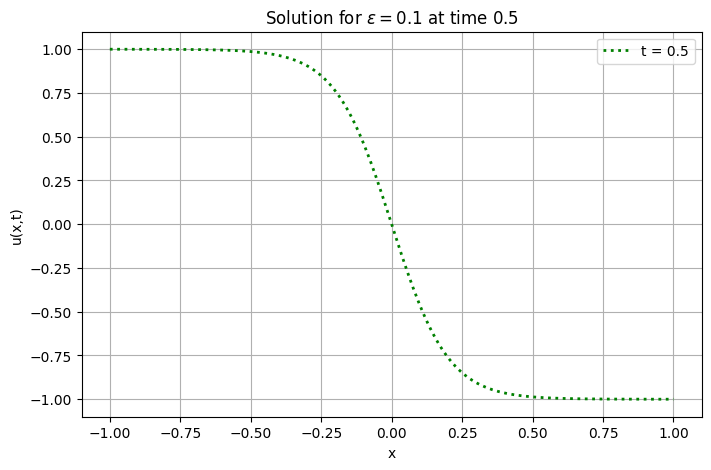

In [49]:
# Actualizamos el código para generar 200 puntos de datos y graficar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.1  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.1))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.1))
        u_new[-1] = -np.tanh(1 / (2*0.1))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t)': solutions[2]  # Columna para los valores de u(x,t)
})

# Guardar los datos en un archivo CSV con 200 puntos
file_path_finite_differences = 'finite_differences_data.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.1$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()



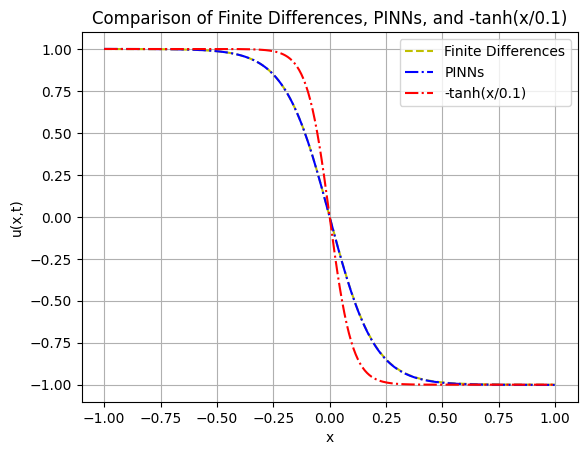

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('finite_differences_data.csv')
pinns_data = pd.read_csv('pinns_data.csv')
tanh_data = pd.read_csv('tanh_data.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'y--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-.', label='PINNs')

# Graficar la solución analítica (-tanh(x/0.1))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/0.1)')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/0.1)')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


In [51]:
import numpy as np
import pandas as pd

# Definir el rango de x
x = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Calcular -tanh(x/0.1)
u_tanh = -np.tanh(x / (2*0.1))

# Crear un DataFrame con los valores de x y u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh
})

# Guardar los datos en un archivo CSV
data.to_csv('tanh01_data.csv', index=False)

print("Datos guardados en 'tanh01_data.csv'")


Datos guardados en 'tanh01_data.csv'


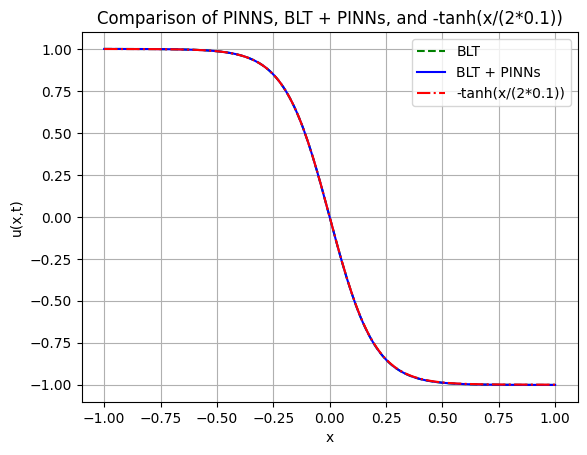

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
blt_data = pd.read_csv('pinns_data.csv')         # PINNS data
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # BLT + PINNs hybrid data
tanh01_data = pd.read_csv('tanh01_data.csv')       # Analytical solution (-tanh(x/0.1))

# Plot the solutions
plt.figure()

# Plot the PINNS solution
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'g--', label='BLT')

# Plot the BLT + PINNs hybrid solution
plt.plot(blt_pinns_data['x'], blt_pinns_data['u_pinns(x,t)'], 'b-', label='BLT + PINNs')

# Plot the analytical solution (-tanh(x/0.1))
plt.plot(tanh01_data['x'], tanh01_data['u(x)'], 'r-.', label='-tanh(x/(2*0.1))')

# Customize the plot
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of PINNS, BLT + PINNs, and -tanh(x/(2*0.1))')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [53]:
import numpy as np
import pandas as pd

# Definir la función de solución BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / np.sqrt(epsilon))

# Parámetro de viscosidad
epsilon = 0.01

# Definir el rango de valores de x (por ejemplo, de -1 a 1)
x_values = np.linspace(-1, 1, 200)  # 200 puntos entre -1 y 1

# Obtener la solución BLT para cada valor de x
blt_solution = blt_boundary_layer_solution(x_values, epsilon)

# Crear un DataFrame para almacenar los valores de x y la solución BLT
blt_data = pd.DataFrame({
    'x': x_values,
    'u_blt(x)': blt_solution
})

# Guardar los datos en un archivo CSV
blt_data.to_csv('blt_data.csv', index=False)

print("Datos BLT guardados en 'blt_data.csv'")


Datos BLT guardados en 'blt_data.csv'


In [54]:
import pandas as pd

# Cargar los datos de los archivos CSV
pinns_data = pd.read_csv('pinns_data.csv')  # Archivo con los datos de PINNs
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # Archivo con los datos de BLT + PINNs
tanh_data = pd.read_csv('tanh_data01.csv')  # Archivo con los datos de la solución analítica (-tanh(x/0.1))

# Combinar los conjuntos de datos en base a la columna 'x' (asumimos que todas comparten los mismos valores de x)
merged_data = pd.merge(pd.merge(pinns_data, blt_pinns_data, on='x'), tanh_data, on='x')

# Verifica el DataFrame combinado
print(merged_data.head())


          x    u(x,t)  u_blt(x)  u_pinns(x,t)  u(x)
0 -1.000000  1.000361       1.0      1.000361   1.0
1 -0.989950  1.000348       1.0      1.000348   1.0
2 -0.979899  1.000334       1.0      1.000334   1.0
3 -0.969849  1.000318       1.0      1.000318   1.0
4 -0.959799  1.000300       1.0      1.000300   1.0


In [55]:
import time

# Measure time for BLT
start_time = time.time()
# Call the function or code block that computes the BLT solution
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)  # Example for BLT solution
end_time = time.time()
blt_computation_time = end_time - start_time
print(f"Computation time for BLT: {blt_computation_time} seconds")

# Measure time for PINNs
start_time = time.time()
# Call the function or code block that computes the PINNs solution (training process)
model.compile("adam", lr=0.001)
model.train(epochs=5000)
end_time = time.time()
pinns_computation_time = end_time - start_time
print(f"Computation time for PINNs: {pinns_computation_time} seconds")

# Measure time for Hybrid (BLT + PINNs)
start_time = time.time()
# Call the function or code block that computes the hybrid BLT + PINNs solution
# You would need to define the hybrid process similar to how you do with PINNs or BLT
end_time = time.time()
hybrid_computation_time = end_time - start_time
print(f"Computation time for Hybrid (BLT + PINNs): {hybrid_computation_time} seconds")


Computation time for BLT: 0.0001633167266845703 seconds
Compiling model...
'compile' took 0.823051 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
5000      [4.93e-01, 1.50e-07, 2.35e-06, 2.47e-06]    [4.93e-01, 1.50e-07, 2.35e-06, 2.47e-06]    []  
6000      [2.15e-03, 9.26e-06, 7.33e-05, 3.99e-03]    [2.15e-03, 9.26e-06, 7.33e-05, 3.99e-03]    []  
7000      [7.87e-04, 2.79e-05, 1.76e-05, 4.95e-04]    [7.87e-04, 2.79e-05, 1.76e-05, 4.95e-04]    []  
8000      [3.60e-04, 1.22e-05, 4.94e-06, 2.41e-04]    [3.60e-04, 1.22e-05, 4.94e-06, 2.41e-04]    []  
9000      [2.02e-04, 1.09e-05, 3.84e-06, 1.95e-04]    [2.02e-04, 1.09e-05, 3.84e-06, 1.95e-04]    []  
10000     [1.40e-04, 2.09e-06, 4.92e-07, 1.52e-04]    [1.40e-04, 2.09e-06, 4.92e-07, 1.52e-04]    []  

Best model at step 3000:
  train loss: 8.04e-06
  test loss: 8.04e-06
  test metric: []

'train' took 49.210508 s

Computation time for PINNs: 50.0432

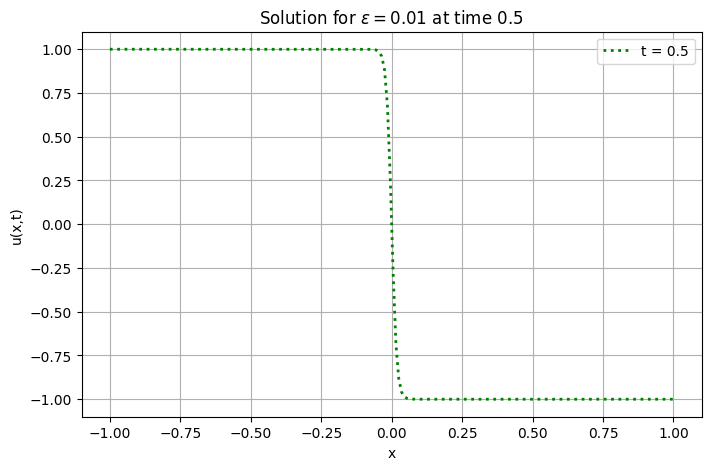

In [56]:
# Actualizamos el código para generar 200 puntos de datos y graficar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.01))
        u_new[-1] = -np.tanh(1 / (2*0.01))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t)': solutions[2]  # Columna para los valores de u(x,t)
})

# Guardar los datos en un archivo CSV con 200 puntos
file_path_finite_differences = '01finite_differences_data.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()



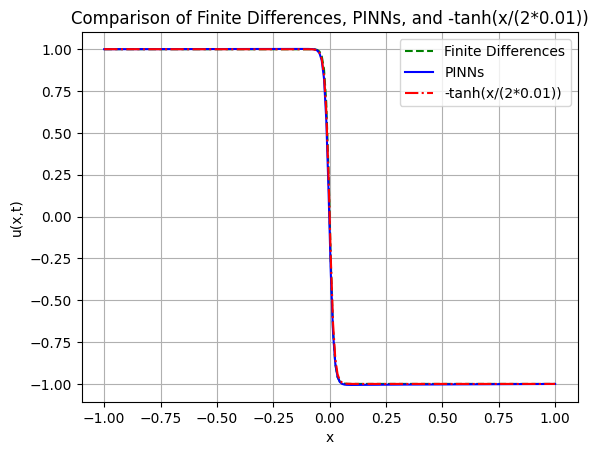

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde los archivos CSV
finite_differences_data = pd.read_csv('01finite_differences_data.csv')
pinns_data = pd.read_csv('pinns_data01.csv')
tanh_data = pd.read_csv('tanh_data01.csv')

# Graficar las soluciones
plt.figure()

# Graficar la solución de diferencias finitas
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'g--', label='Finite Differences')

# Graficar la solución de PINNs
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-', label='PINNs')

# Graficar la solución analítica (-tanh(x/0.01))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Personalización del gráfico
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/(2*0.01))')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.112553 s

'compile' took 1.967618 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e-02, 3.73e-01, 4.02e-01, 4.66e-01]    [1.00e-02, 3.73e-01, 4.02e-01, 4.66e-01]    []  
1000      [5.52e-05, 2.37e-07, 2.01e-06, 1.04e-06]    [5.52e-05, 2.37e-07, 2.01e-06, 1.04e-06]    []  
2000      [2.87e-05, 1.20e-05, 1.24e-05, 4.06e-06]    [2.87e-05, 1.20e-05, 1.24e-05, 4.06e-06]    []  
3000      [7.71e-06, 7.81e-08, 4.91e-08, 8.64e-07]    [7.71e-06, 7.81e-08, 4.91e-08, 8.64e-07]    []  
4000      [5.71e-06, 1.91e-06, 1.72e-06, 7.90e-07]    [5.71e-06, 1.91e-06, 1.72e-06, 7.90e-07]    []  
5000      [3.17e-06, 2.03e-08, 5.37e-08, 4.15e-07]    [3.17e-06, 2.03e-08, 5.37e-08, 4.15e-07]    []  

Best model at step 5000:
  train loss: 3.66e-06
  test loss: 3.66e-06
  test metric: []

'train' took 53.229180 s

Compiling model...
Buildin

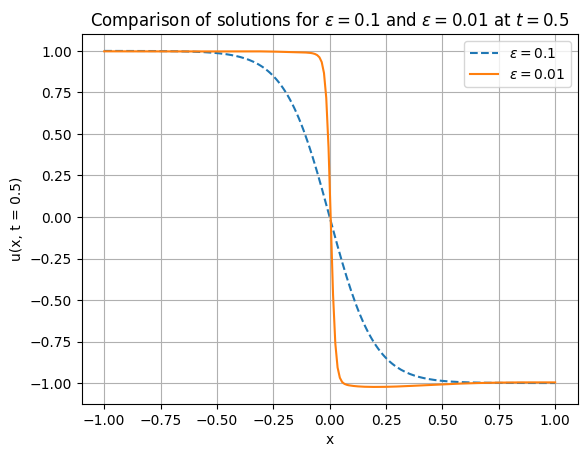

In [58]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u, epsilon):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los dominios espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Condición inicial u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.1)), lambda _, on_initial: on_initial)

# Definir los problemas para epsilon = 0.1 y epsilon = 0.01
epsilons = [0.1, 0.01]
solutions = []

for epsilon in epsilons:
    # Definir el problema para cada epsilon
    data = dde.data.TimePDE(geomtime, lambda x, u: burgers_equation(x, u, epsilon), [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Definir la red neuronal
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Definir el modelo
    model = dde.Model(data, net)

    # Entrenar el modelo
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generar puntos para predecir en t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Graficar las soluciones para epsilon = 0.1 y epsilon = 0.01
plt.figure()
plt.plot(x_vals, solutions[0], label=r"$\epsilon = 0.1$", linestyle='--')
plt.plot(x_vals, solutions[1], label=r"$\epsilon = 0.01$", linestyle='-')
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for $\epsilon = 0.1$ and $\epsilon = 0.01$ at $t = 0.5$")
plt.grid(True)
plt.show()


# Gaussian Profile

Compiling model...
Building feed-forward neural network...
'build' took 0.148142 s

'compile' took 5.839973 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 3.99e-01, 2.50e-01]    [1.16e-02, 3.73e-01, 3.99e-01, 2.50e-01]    []  
1000      [3.32e-02, 5.71e-03, 1.51e-02, 3.44e-02]    [3.32e-02, 5.71e-03, 1.51e-02, 3.44e-02]    []  
2000      [6.85e-03, 5.22e-04, 3.04e-04, 9.95e-03]    [6.85e-03, 5.22e-04, 3.04e-04, 9.95e-03]    []  
3000      [2.69e-03, 3.86e-04, 1.97e-04, 3.26e-03]    [2.69e-03, 3.86e-04, 1.97e-04, 3.26e-03]    []  
4000      [1.66e-03, 3.33e-04, 2.06e-04, 2.41e-03]    [1.66e-03, 3.33e-04, 2.06e-04, 2.41e-03]    []  
5000      [1.26e-03, 2.79e-04, 1.72e-04, 1.56e-03]    [1.26e-03, 2.79e-04, 1.72e-04, 1.56e-03]    []  

Best model at step 5000:
  train loss: 3.27e-03
  test loss: 3.27e-03
  test metric: []

'train' took 61.002142 s

Compiling model...
Buildin

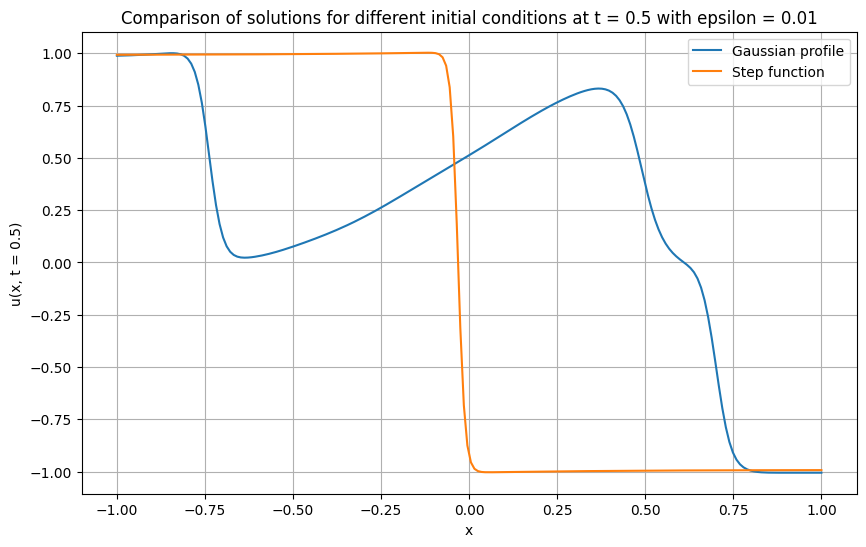

In [59]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para la ecuación
epsilon = 0.01  # Viscosidad

# Definir la ecuación de Burgers con viscosidad
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Definir los dominios espaciales y temporales
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Definir las condiciones de frontera
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Definir la condición inicial: perfil gaussiano
def gaussian_ic(x):
    return np.exp(-10 * (x[:, 0:1])**2)  # Condición inicial gaussiana

# Definir la condición inicial: función de paso
def step_function_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)  # Condición inicial de paso

# Crear una lista de condiciones iniciales (gaussiana y función de paso)
initial_conditions = [gaussian_ic, step_function_ic]
initial_labels = ["Gaussian profile", "Step function"]
solutions = []

# Realizar simulaciones para ambas condiciones iniciales
for ic_func in initial_conditions:
    # Definir la condición inicial para el caso actual
    ic = dde.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

    # Definir el problema
    data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Definir la red neuronal
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Definir el modelo
    model = dde.Model(data, net)

    # Entrenar el modelo
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generar puntos para predecir en t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Graficar las soluciones para las dos condiciones iniciales
plt.figure(figsize=(10, 6))
for i, label in enumerate(initial_labels):
    plt.plot(x_vals, solutions[i], label=label)
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for different initial conditions at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()


In [60]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")
